# Image Filtering Module: Pyramids

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Display pyramid function


In [6]:
def plot_pyramids(image_list, images_per_row):
    N = image_list.__len__()
    rows = (N + images_per_row - 1) // images_per_row

    fig_width = 512 * images_per_row / 100  # Convert pixels to inches (assuming 100 dpi)
    fig_height = 512 * rows / 100  # Convert pixels to inches (assuming 100 dpi)
    
    fig, ax = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(fig_width, fig_height), dpi=100)
    axes = ax.flatten()

    for k in range(N-1, -1, -1):
        img = image_list[k]
        axes[k].imshow(img, aspect='auto')
        axes[k].set_xlim(0, 512)
        axes[k].set_ylim(512, 0)



# Resize image

In [3]:
def resize_image(image, target_width, target_height):
    original_height, original_width = image.shape[:2]

    resized_image = np.zeros((target_height, target_width, 3), dtype=image.dtype)

    x_scale = original_width / target_width
    y_scale = original_height / target_height

    for i in range(target_height):
        for j in range(target_width):
            x = min(int(j * x_scale), original_width - 1)
            y = min(int(i * y_scale), original_height - 1)
            resized_image[i, j] = image[y, x]

    return resized_image

# Separable convolution

In [4]:
def separable_convolution(im_channel, h):
    height, width = im_channel.shape
    temp_result = np.zeros((height, width))
    filter_len = len(h)
    pad = filter_len // 2
    
    padded_channel = np.pad(im_channel, ((0, 0), (pad, pad)), mode='reflect')
    
    for i in range(height):
        for j in range(width):
            temp_result[i, j] = np.sum(padded_channel[i, j:j+filter_len] * h)
    
    final_result = np.zeros((height, width))
    padded_temp_result = np.pad(temp_result, ((pad, pad), (0, 0)), mode='reflect')
    
    for i in range(height):
        for j in range(width):
            final_result[i, j] = np.sum(padded_temp_result[i:i+filter_len, j] * h)
    
    return final_result

## Pyramids

### Gaussian Pyramid
Pyramids are a way to reduce the dimensionality down to a smaller size for computational efficiency by walking down the pyramid (slightly burring then down-sampling the image to make the image smaller).

This method will retain all the Fourier information from the smaller images at each larger interval

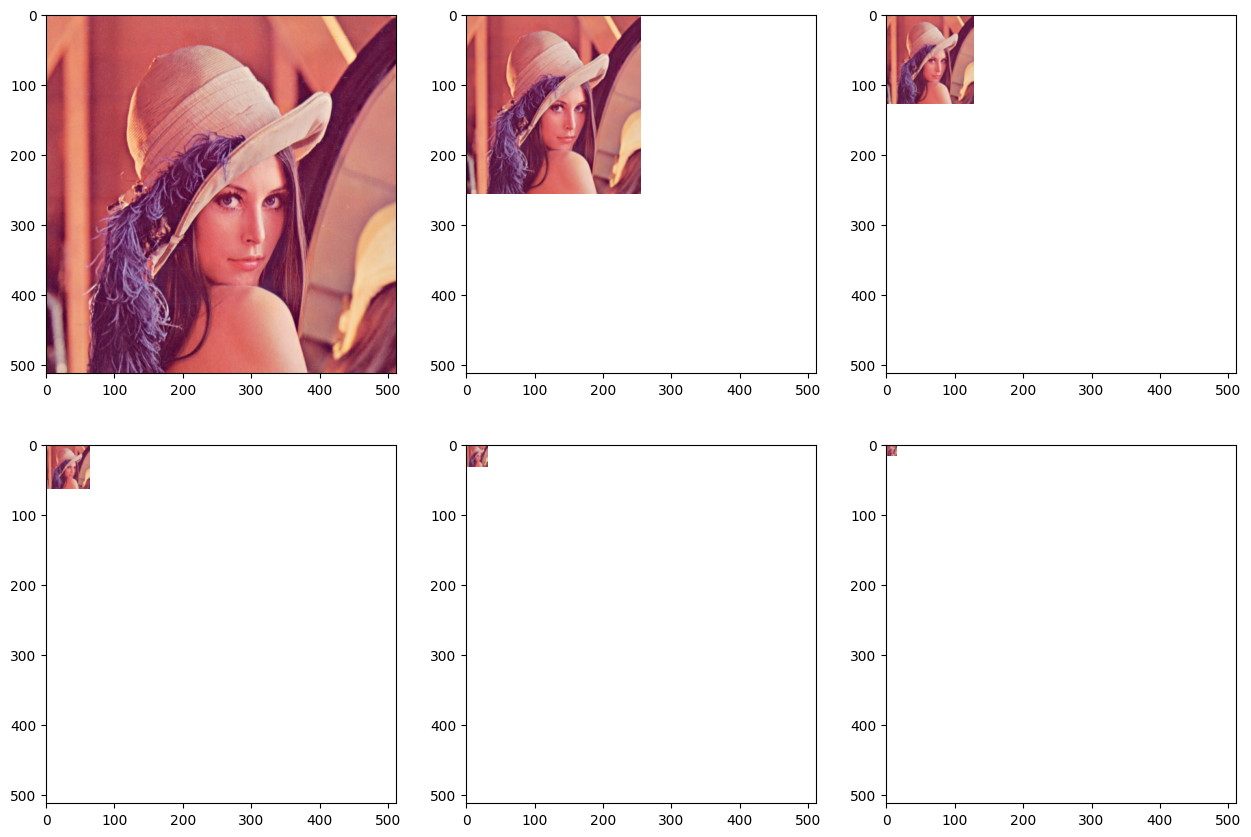

In [7]:
im = plt.imread('Lenna_(test_image).png')
h = [1/16, 4/16, 6/16, 4/16, 1/16]; # blur filter - values sum to 1
N = 6 # Number of pyramid levels

G = [] # This will store our pyramid
G.append(im) # first pyramid level
for k in range(1,N): # add the other pyramid levels
    im2 = np.zeros( im.shape )
    for z in range(3): # Three channels because image is color
        im2[:,:,z] = separable_convolution( im[:,:,z], h) # type: ignore # blur each color channel with the separable filter
    im = im2[0:-1:2, 0:-1:2, :] # down sample by removing every other pixel
    G.append(im)
    
# display pyramid
plot_pyramids(G, 3) 

### Laplacian Pyramids

These are similar to Gaussian Pyramids but will describe the difference in Fourier frequency space between each layer of the Gaussian pyramid. In this way we're able to do analysis on specific frequencies present at each of the levels (rather than a cumulative representation of all lower levels). 

We can accomplish this by first building out a Gaussian Pyramid and then at each layer up-sampling and taking the difference between the up-sampled image and the original image (before it was down-sampled) at that level. 

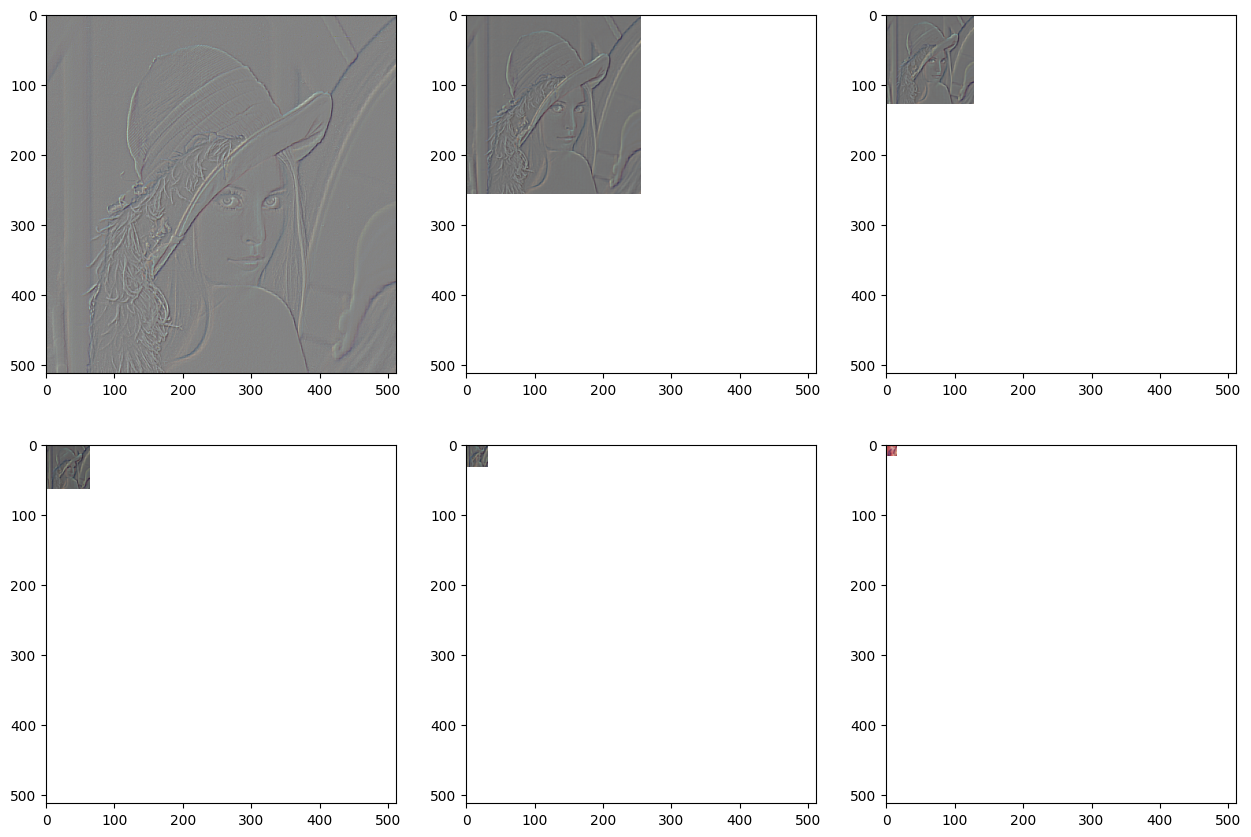

In [44]:
  
L = [] # Laplacian pyramid
for k in range(0, N-1): # build Laplacian pyramid from Gaussian
    l1 = G[k]
    l2 = G[k+1]
    l2 = resize_image(l2, l1.shape[1], l1.shape[0]) # type: ignore # up-sample
    D = l1 - l2 # take difference between the Gaussian pyramid level (k) and the up-sampled (k+1) level
    D = D - np.min(D) # scale in [0,1]
    # D = D / np.max(D) # for display purposes
    L.append(D)
L.append(G[N-1])

# display pyramid
plot_pyramids(L, 3) 
    

### Backward for recreate first image with Laplacian pyramid

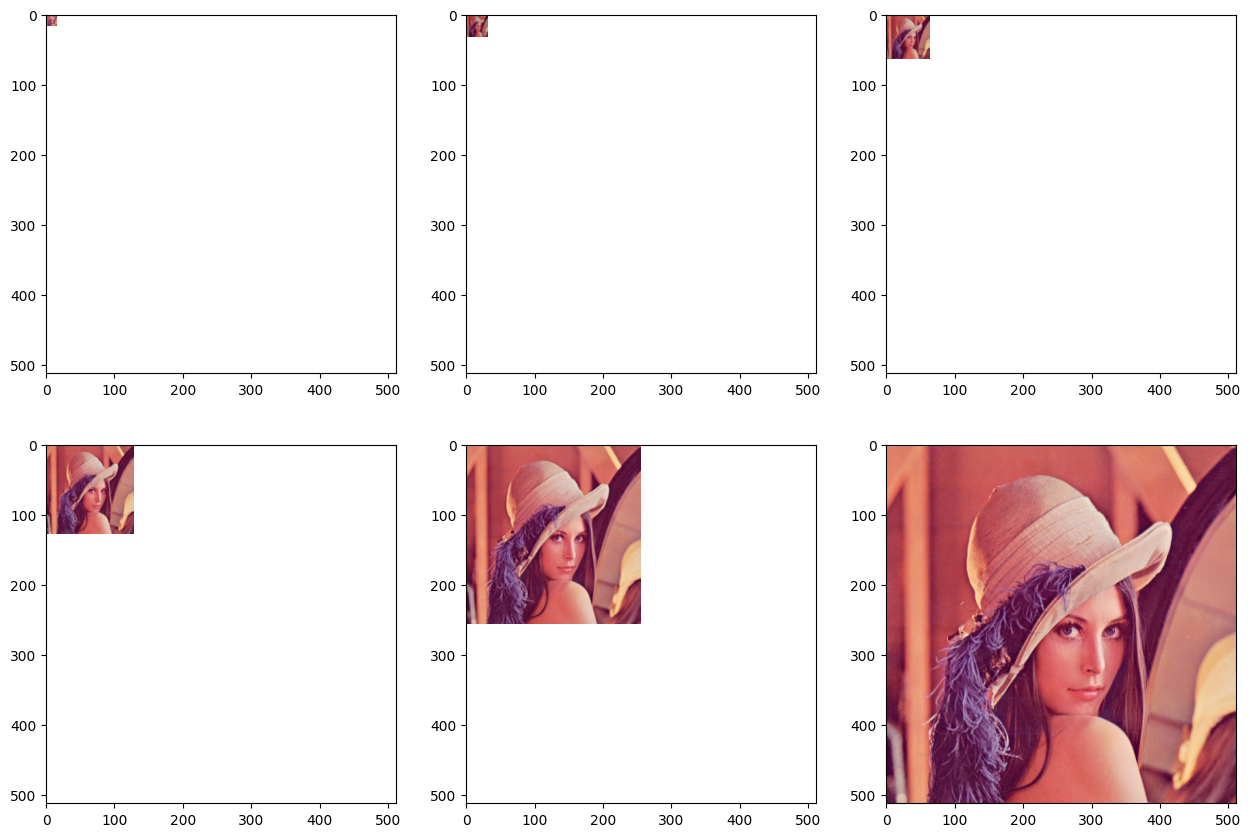

In [45]:
backward_laplacian = []
backward_laplacian.append(L[N-1])
for i in range (N-2,-1,-1):
    smaller_image = backward_laplacian[N-i-2]
    greater_l = L[i]
    smaller_image = resize_image(smaller_image, greater_l.shape[1], greater_l.shape[0]) # type: ignore # up-sample

    first_image = smaller_image + greater_l
    first_image = first_image - np.min(first_image) # scale in [0,1]
    # first_image = first_image / np.max(first_image) # for display purposes
    backward_laplacian.append(first_image)

plot_pyramids(backward_laplacian, 3) 